## Preparing the Data

In [the previous tutorial](https://jovian.ai/aakashns/03-logistic-regression), we trained a logistic regression model to identify handwritten digits from the MNIST dataset with an accuracy of around 86%. The dataset consists of 28px by 28px grayscale images of handwritten digits (0 to 9) and labels for each image indicating which digit it represents. Here are some sample images from the dataset:

![mnist-sample](https://i.imgur.com/CAYnuo1.jpg)

We noticed that it's quite challenging to improve the accuracy of a logistic regression model beyond 87%, since the model assumes a linear relationship between pixel intensities and image labels. In this post, we'll try to improve upon it  using a *feed-forward neural network* which can capture non-linear relationships between inputs and targets.

Let's begin by installing and importing the required modules and classes from `torch`, `torchvision`, `numpy`, and `matplotlib`.

In [1]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

# Use a white background for matplotlib figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [2]:
dataset = MNIST(root='data/', download=True, transform=ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [3]:
print(dataset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data/
    Split: Train
    StandardTransform
Transform: ToTensor()


Let's look at a couple of images from the dataset. The images are converted to PyTorch tensors with the shape `1x28x28` (the dimensions represent color channels, width and height). We can use `plt.imshow` to display the images. However, `plt.imshow` expects channels to be last dimension in an image tensor, so we use the `permute` method to reorder the dimensions of the image.

In [4]:
image, label = dataset[0]
print('image.shape:', image.shape)
image_permuted = image.permute(1, 2, 0)
image_permuted.shape

image.shape: torch.Size([1, 28, 28])


torch.Size([28, 28, 1])

Label: 5


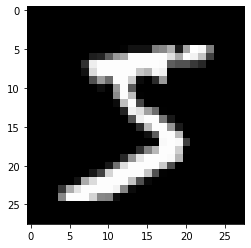

In [5]:
plt.imshow(image[0], cmap='gray')
print('Label:', label)

Next, let's use the `random_split` helper function to set aside 10000 images for our validation set.

In [6]:
val_size = 10000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

In [7]:
batch_size=100

In [8]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Can you figure out the purpose of the arguments `num_workers` and `pin_memory`? Try looking into the documentation: https://pytorch.org/docs/stable/data.html .

Let's visualize a batch of data in a grid using the `make_grid` function from `torchvision`. We'll also use the `.permute` method on the tensor to move the channels to the last dimension, as expected by `matplotlib`.

images.shape: torch.Size([100, 1, 28, 28])


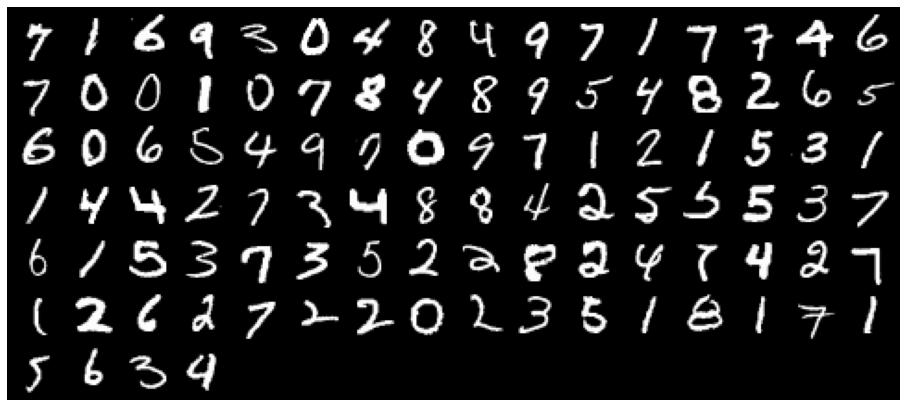

In [9]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

## Hidden Layers, Activation Functions and Non-Linearity

We'll create a neural network with two layers: a _hidden layer_ and an _output layer_. Additionally, we'll use an _activation function_ between the two layers. Let's look at a step-by-step example to learn how hidden layers and activation functions can help capture non-linear relationships between inputs and outputs.

First, let's create a batch of inputs tensors. We'll flatten the `1x28x28` images into vectors of size `784`, so they can be passed into an `nn.Linear` object.

In [10]:
for images, labels in train_loader:
    print('images.shape:', images.shape)
    inputs = images.reshape(-1, 784)
    # flatten it
    print('inputs.shape:', inputs.shape)
    break

images.shape: torch.Size([100, 1, 28, 28])
inputs.shape: torch.Size([100, 784])


Next, let's create a `nn.Linear` object, which will serve as our _hidden_ layer. We'll set the size of the output from the hidden layer to 32. This number can be increased or decreased to change the _learning capacity_ of the model.

In [11]:
input_size = inputs.shape[-1]
hidden_size = 32

In [12]:
layer1 = nn.Linear(input_size, hidden_size)

We can now compute intermediate outputs for the batch of images by passing `inputs` through `layer1`.

In [13]:
inputs.shape

torch.Size([100, 784])

In [14]:
layer1_outputs = layer1(inputs)
print('layer1_outputs.shape:', layer1_outputs.shape)

layer1_outputs.shape: torch.Size([100, 32])


In [15]:
layer1_outputs_direct = inputs @ layer1.weight.t() + layer1.bias
layer1_outputs_direct.shape

torch.Size([100, 32])

In [16]:
torch.allclose(layer1_outputs, layer1_outputs_direct, 1e-3)

# we use this because floats can't use == to compare, so use close

True

Thus, `layer1_outputs` and `inputs` have a linear relationship, i.e., each element of `layer_outputs` is a weighted sum of elements from `inputs`. Thus, even as we train the model and modify the weights, `layer1` can only capture linear relationships between `inputs` and `outputs`.

<img src="https://i.imgur.com/inXsLuq.png" width="360">

Next, we'll use the Rectified Linear Unit (ReLU) function as the activation function for the outputs. It has the formula `relu(x) = max(0,x)` i.e. it simply replaces negative values in a given tensor with the value 0. ReLU is a non-linear function, as seen here visually:

<img src="https://i.imgur.com/yijV4xF.png" width="420">

We can use the `F.relu` method to apply ReLU to the elements of a tensor.

In [17]:
# examples
F.relu(torch.tensor([[1, -1, 0], 
                     [-0.1, .2, 3]]))

tensor([[1.0000, 0.0000, 0.0000],
        [0.0000, 0.2000, 3.0000]])

In [18]:
relu_outputs = F.relu(layer1_outputs)
print(layer1_outputs)
print(relu_outputs)
print("relu shape", relu_outputs.shape)
print('min(layer1_outputs):', torch.min(layer1_outputs).item())
print('min(relu_outputs):', torch.min(relu_outputs).item())

tensor([[-0.0537,  0.0190, -0.1762,  ...,  0.2916,  0.0305,  0.1746],
        [-0.2632, -0.0438, -0.2177,  ..., -0.1403, -0.0799,  0.0806],
        [-0.0205,  0.2508, -0.1125,  ...,  0.3339, -0.0202, -0.3440],
        ...,
        [-0.0305,  0.1134, -0.0765,  ...,  0.1956, -0.0076,  0.1929],
        [ 0.2180,  0.5247,  0.0410,  ...,  0.0429,  0.0810, -0.0815],
        [ 0.1222,  0.0718, -0.1104,  ...,  0.2142,  0.0101, -0.1220]],
       grad_fn=<AddmmBackward0>)
tensor([[0.0000, 0.0190, 0.0000,  ..., 0.2916, 0.0305, 0.1746],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0806],
        [0.0000, 0.2508, 0.0000,  ..., 0.3339, 0.0000, 0.0000],
        ...,
        [0.0000, 0.1134, 0.0000,  ..., 0.1956, 0.0000, 0.1929],
        [0.2180, 0.5247, 0.0410,  ..., 0.0429, 0.0810, 0.0000],
        [0.1222, 0.0718, 0.0000,  ..., 0.2142, 0.0101, 0.0000]],
       grad_fn=<ReluBackward0>)
relu shape torch.Size([100, 32])
min(layer1_outputs): -0.6030248999595642
min(relu_outputs): 0.0


Now that we've applied a non-linear activation function, `relu_outputs` and `inputs` do not have a linear relationship. We refer to `ReLU` as the _activation function_, because for each input certain outputs are activated (those with non-zero values) while others turned off (those with zero values)

Next, let's create an output layer to convert vectors of length `hidden_size` in `relu_outputs` into vectors of length 10, which is the desired output of our model (since there are 10 target labels).

In [19]:
output_size2 = 10
layer2 = nn.Linear(hidden_size, output_size2)

In [20]:
layer2_outputs = layer2(relu_outputs)
print(layer2_outputs.shape)

torch.Size([100, 10])


In [21]:
inputs.shape

torch.Size([100, 784])

As expected, `layer2_outputs` contains a batch of vectors of size 10. We can now use this output to compute the loss using `F.cross_entropy` and adjust the weights of `layer1` and `layer2` using gradient descent.

In [22]:
F.cross_entropy(layer2_outputs, labels)

tensor(2.2964, grad_fn=<NllLossBackward0>)

Thus, our model transforms `inputs` into `layer2_outputs` by applying a linear transformation (using `layer1`), followed by a non-linear activation (using `F.relu`), followed by another linear transformation (using `layer2`). Let's verify this by re-computing the output using basic matrix operations.

In [23]:
# Expanded version of layer2(F.relu(layer1(inputs)))
outputs = (F.relu(inputs @ layer1.weight.t() + layer1.bias)) @ layer2.weight.t() + layer2.bias

In [24]:
torch.allclose(outputs, layer2_outputs, 1e-3)

True

Note that `outputs` and `inputs` do not have a linear relationship due to the non-linear activation function `F.relu`. As we train the model and adjust the weights of `layer1` and `layer2`, we can now capture non-linear relationships between the images and their labels. In other words, introducing non-linearity makes the model more powerful and versatile. Also, since `hidden_size` does not depend on the dimensions of the inputs or outputs, we vary it to increase the number of parameters within the model. We can also introduce new hidden layers and apply the same non-linear activation after each hidden layer.

The model we just created is called a neural network. A _deep neural network_ is simply a neural network with one or more hidden layers. In fact, the [Universal Approximation Theorem](http://neuralnetworksanddeeplearning.com/chap4.html) states that a sufficiently large & deep neural network can compute any arbitrary function i.e. it can _learn_ rich and complex non-linear relationships between inputs and targets. Here are some examples:

* Identifying if an image contains a cat or a dog (or [something else](https://machinelearningmastery.com/introduction-to-the-imagenet-large-scale-visual-recognition-challenge-ilsvrc/))
* Identifying the genre of a song using a 10-second sample
* Classifying movie reviews as positive or negative based on their content
* Navigating self-driving cars using a video feed of the road
* Translating sentences from English to French (and hundreds of other languages)
* Converting a speech recording to text and vice versa
* And many more...

It's hard to imagine how the simple process of multiplying inputs with randomly initialized matrices, applying non-linear activations, and adjusting weights repeatedly using gradient descent can yield such astounding results. Deep learning models often contain millions of parameters, which can together capture far more complex relationships than the human brain can comprehend.

If we hadn't included a non-linear activation between the two linear layers, the final relationship between inputs and outputs would still be linear. A simple refactoring of the computations illustrates this.


In [25]:
# Same as layer2(layer1(inputs))
outputs2 = (inputs @ layer1.weight.t() + layer1.bias) @ layer2.weight.t() + layer2.bias

In [26]:
# Create a single layer to replace the two linear layers
combined_layer = nn.Linear(input_size, output_size2)

combined_layer.weight.data = layer2.weight @ layer1.weight
combined_layer.bias.data = layer1.bias @ layer2.weight.t() + layer2.bias

In [27]:
# Same as combined_layer(inputs)
outputs3 = inputs @ combined_layer.weight.t() + combined_layer.bias

In [28]:
torch.allclose(outputs2, outputs3, 1e-3)

True

## Model

We are now ready to define our model. As discussed above, we'll create a neural network with one hidden layer. Here's what that means:

* Instead of using a single `nn.Linear` object to transform a batch of inputs (pixel intensities) into outputs (class probabilities), we'll use two `nn.Linear` objects. Each of these is called a _layer_ in the network. 

* The first layer (also known as the hidden layer) will transform the input matrix of shape `batch_size x 784` into an intermediate output matrix of shape `batch_size x hidden_size`. The parameter `hidden_size` can be configured manually (e.g., 32 or 64).

* We'll then apply a non-linear *activation function* to the intermediate outputs. The activation function transforms individual elements of the matrix.

* The result of the activation function, which is also of size `batch_size x hidden_size`, is passed into the second layer (also known as the output layer).  The second layer transforms it into a matrix of size `batch_size x 10`. We can use this output to compute the loss and adjust weights using gradient descent.


As discussed above, our model will contain one hidden layer. Here's what it looks like visually:

<img src="https://i.imgur.com/eN7FrpF.png" width="480">


Let's define the model by extending the `nn.Module` class from PyTorch.

In [29]:
class MnistModel(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        # output layer
        self.linear2 = nn.Linear(hidden_size, out_size)
        
    def forward(self, xb):
        # Flatten the image tensors
        xb = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply activation function
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linear2(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [30]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [31]:
input_size = 784
hidden_size = 30 # you can change this
num_classes = 10

In [32]:
model = MnistModel(input_size, hidden_size=30, out_size=num_classes)

In [33]:
for t in model.parameters():
    print(t.shape)

torch.Size([30, 784])
torch.Size([30])
torch.Size([10, 30])
torch.Size([10])


Let's try and generate some outputs using our model. We'll take the first batch of 128 images from our dataset and pass them into our model.

In [34]:
for images, labels in train_loader:
    outputs = model(images)
    #print(outputs)
    loss = F.cross_entropy(outputs, labels)
    print('Loss:', loss.item())
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

Loss: 2.292346239089966
outputs.shape :  torch.Size([100, 10])
Sample outputs :
 tensor([[-0.0059,  0.0379,  0.0091, -0.0964,  0.1185,  0.0371,  0.1492, -0.1111,
          0.0295, -0.1441],
        [-0.1798,  0.0143,  0.0065, -0.1241,  0.2130, -0.0621,  0.1034, -0.0715,
         -0.1011, -0.1133]])


## Using a GPU

As the sizes of our models and datasets increase, we need to use GPUs to train our models within a reasonable amount of time. GPUs contain hundreds of cores optimized for performing expensive matrix operations on floating-point numbers quickly, making them ideal for training deep neural networks. You can use GPUs for free on [Google Colab](https://colab.research.google.com/) and [Kaggle](https://www.kaggle.com/kernels) or rent GPU-powered machines on services like [Google Cloud Platform](https://cloud.google.com/gpu/), [Amazon Web Services](https://docs.aws.amazon.com/dlami/latest/devguide/gpu.html), and [Paperspace](https://www.paperspace.com/).

We can check if a GPU is available and the required NVIDIA CUDA drivers are installed using `torch.cuda.is_available`.

In [35]:
torch.cuda.is_available()

True

Let's define a helper function to ensure that our code uses the GPU if available and defaults to using the CPU if it isn't. 

In [36]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [37]:
device = get_default_device()
device

device(type='cuda')

Next, let's define a function that can move data and model to a chosen device.

In [38]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [39]:
for images, labels in train_loader:
    print(images.shape)
    images = to_device(images, device)
    print(images.device)
    break

torch.Size([100, 1, 28, 28])
cuda:0


Finally, we define a `DeviceDataLoader` class to wrap our existing data loaders and move batches of data to the selected device. Interestingly, we don't need to extend an existing class to create a PyTorch datal oader. All we need is an `__iter__` method to retrieve batches of data and an `__len__` method to get the number of batches.

In [40]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

The `yield` keyword in Python is used to create a generator function that can be used within a `for` loop, as illustrated below.

In [41]:
def some_numbers():
    yield 10
    yield 20
    yield 30

for value in some_numbers():
    print(value)

10
20
30


In [42]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [43]:
for xb, yb in val_loader:
    print('xb.device:', xb.device)
    print('yb:', yb)
    break

xb.device: cuda:0
yb: tensor([2, 0, 9, 7, 8, 9, 7, 9, 3, 9, 8, 4, 2, 8, 7, 6, 7, 0, 9, 5, 2, 2, 3, 8,
        8, 4, 8, 1, 1, 2, 9, 8, 2, 2, 7, 3, 4, 2, 8, 0, 1, 5, 5, 1, 9, 7, 8, 9,
        9, 6, 7, 3, 2, 2, 0, 0, 6, 7, 6, 9, 7, 4, 9, 0, 7, 2, 1, 8, 7, 1, 0, 9,
        6, 6, 9, 2, 7, 3, 3, 1, 1, 4, 9, 9, 4, 4, 6, 2, 9, 1, 0, 3, 6, 8, 2, 9,
        0, 8, 4, 4, 3, 7, 1, 6, 5, 5, 0, 4, 0, 2, 3, 4, 2, 4, 2, 6, 1, 0, 3, 2,
        5, 1, 6, 4, 1, 3, 2, 1, 7, 3, 5, 2, 3, 0, 4, 0, 5, 3, 3, 1, 9, 1, 7, 1,
        2, 9, 3, 3, 8, 9, 8, 3, 6, 3, 2, 8, 6, 1, 3, 7, 9, 2, 3, 1, 8, 9, 9, 3,
        8, 1, 5, 2, 2, 3, 6, 8, 8, 0, 1, 9, 1, 5, 3, 6, 7, 3, 7, 4, 9, 4, 0, 2,
        5, 2, 0, 5, 3, 9, 1, 0], device='cuda:0')


## Training the Model

We'll define two functions: `fit` and `evaluate` to train the model using gradient descent and evaluate its performance on the validation set. For a detailed walkthrough of these functions, check out the [previous tutorial](https://jovian.ai/aakashns/03-logistic-regression).

In [44]:
def evaluate(model, val_loader):
    """Evaluate the model's performance on the validation set"""
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    """Train the model using gradient descent"""
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

Before we train the model, we need to ensure that the data and the model's parameters (weights and biases) are on the same device (CPU or GPU). We can reuse the `to_device` function to move the model's parameters to the right device. 

In [45]:
# Model (on GPU)
model = MnistModel(input_size, hidden_size=hidden_size, out_size=num_classes)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=30, bias=True)
  (linear2): Linear(in_features=30, out_features=10, bias=True)
)

Let's see how the model performs on the validation set with the initial set of weights and biases.

In [46]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 2.3053407669067383, 'val_acc': 0.10250000655651093}]

The initial accuracy is around 10%, as one might expect from a randomly initialized model (since it has a 1 in 10 chance of getting a label right by guessing randomly).

Let's train the model for five epochs and look at the results. We can use a relatively high learning rate of 0.5.

In [47]:
history += fit(5, 0.5, model, train_loader, val_loader)

Epoch [0], val_loss: 0.2306, val_acc: 0.9298
Epoch [1], val_loss: 0.1735, val_acc: 0.9458
Epoch [2], val_loss: 0.1620, val_acc: 0.9509
Epoch [3], val_loss: 0.1479, val_acc: 0.9559
Epoch [4], val_loss: 0.1370, val_acc: 0.9579


96% is pretty good! Let's train the model for five more epochs at a lower learning rate of 0.1 to improve the accuracy further.

In [48]:
history += fit(5, 0.1, model, train_loader, val_loader)

Epoch [0], val_loss: 0.1180, val_acc: 0.9645
Epoch [1], val_loss: 0.1172, val_acc: 0.9634
Epoch [2], val_loss: 0.1177, val_acc: 0.9637
Epoch [3], val_loss: 0.1163, val_acc: 0.9645
Epoch [4], val_loss: 0.1156, val_acc: 0.9652


In [49]:
print(history)

[{'val_loss': 2.3053407669067383, 'val_acc': 0.10250000655651093}, {'val_loss': 0.23059499263763428, 'val_acc': 0.9298000335693359}, {'val_loss': 0.17346318066120148, 'val_acc': 0.9457999467849731}, {'val_loss': 0.16196751594543457, 'val_acc': 0.9509000182151794}, {'val_loss': 0.1478700339794159, 'val_acc': 0.9558999538421631}, {'val_loss': 0.13696973025798798, 'val_acc': 0.9578999280929565}, {'val_loss': 0.11796335130929947, 'val_acc': 0.9644999504089355}, {'val_loss': 0.11718203872442245, 'val_acc': 0.9634000658988953}, {'val_loss': 0.11770578473806381, 'val_acc': 0.9637000560760498}, {'val_loss': 0.11625602096319199, 'val_acc': 0.9644999504089355}, {'val_loss': 0.115601547062397, 'val_acc': 0.9651999473571777}]


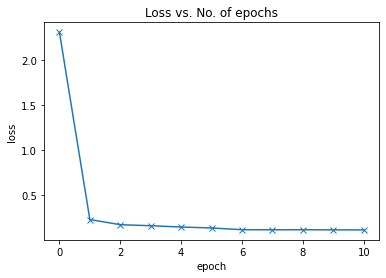

In [50]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

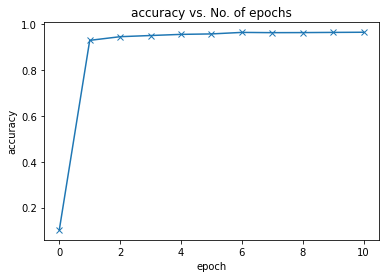

In [51]:
accuracy = [x['val_acc'] for x in history]
plt.plot(accuracy, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('accuracy vs. No. of epochs');

Our current model outperforms the logistic regression model (which could only achieve around 86% accuracy) by a considerable margin! It quickly reaches an accuracy of 97% but doesn't improve much beyond this. To improve accuracy further, we need to make the model more powerful by increasing the hidden layer's size or adding more hidden layers with activations. I encourage you to try out both these approaches and see which one works better.

## Testing with individual images

While we have been tracking the overall accuracy of a model so far, it's also a good idea to look at model's results on some sample images. Let's test out our model with some images from the predefined test dataset of 10000 images. We begin by recreating the test dataset with the `ToTensor` transform.

In [52]:
# Define test dataset
test_dataset = MNIST(root='data/', 
                     train=False,
                     transform=ToTensor())

In [53]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

In [54]:
test_dataset[0]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

Label: 7 , Predicted: 7


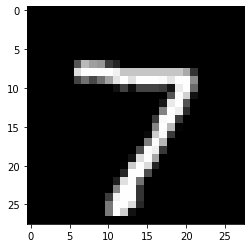

In [55]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 2 , Predicted: 2


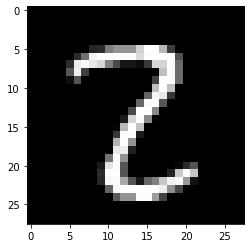

In [56]:
img, label = test_dataset[1839]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 9 , Predicted: 9


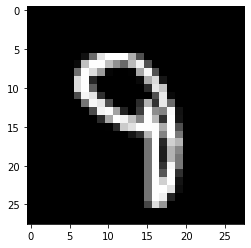

In [57]:
img, label = test_dataset[193]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Identifying where our model performs poorly can help us improve the model, by collecting more training data, increasing/decreasing the complexity of the model, and changing the hypeparameters.

As a final step, let's also look at the overall loss and accuracy of the model on the test set.

In [60]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size=100), device)
# result = evaluate(model, test_loader)
# result

now try multi-layer

In [61]:
val_size = 10000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)
batch_size=100
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

In [62]:
train_ds

In [63]:
# use dataloader
counter=0
for epoch in [1,2,3]:
    for batch,label in train_loader:
        if counter==0:
            print(batch,label)
            counter+=1
        print(batch.size(),label.size())

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0.

In [64]:
val_ds

In [65]:
for images, labels in train_loader:
    print('images.shape:', images.shape)
    inputs = images.reshape(-1, 784)
    # flatten it
    print('inputs.shape:', inputs.shape)
    break

images.shape: torch.Size([100, 1, 28, 28])
inputs.shape: torch.Size([100, 784])


Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


In [66]:
class MnistModel_2(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, hidden_size1, hidden_size2, hidden_size3, out_size):
        super().__init__()
        # hidden layer1
        self.linear1 = nn.Linear(in_size, hidden_size1)
        # hidden layer2
        self.linear2 = nn.Linear(hidden_size1, hidden_size2)
        # hidden layer3
        self.linear3 = nn.Linear(hidden_size2, hidden_size3)
        # output layer
        self.linear_output = nn.Linear(hidden_size3, out_size)
        
    def forward(self, xb):
        # Flatten the image tensors
        xb = xb.view(xb.size(0), -1)

        # layer1
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply activation function
        out = F.relu(out)

        # layer2
        # Get intermediate outputs using hidden layer
        out = self.linear2(out)
        # Apply activation function
        out = F.relu(out)

        # layer3
        # Get intermediate outputs using hidden layer
        out = self.linear3(out)
        # Apply activation function
        out = F.relu(out)


        # Get predictions using output layer
        out = self.linear_output(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [67]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [68]:
input_size = 784

hidden_size1 = 64 # you can change this
hidden_size2 = 32
hidden_size3 = 16

num_classes = 10

In [69]:
model_2 = MnistModel_2(input_size, hidden_size1 = 64, hidden_size2 = 32, hidden_size3 = 16, out_size=num_classes)

In [70]:
for t in model_2.parameters():
    print(t.shape)

torch.Size([64, 784])
torch.Size([64])
torch.Size([32, 64])
torch.Size([32])
torch.Size([16, 32])
torch.Size([16])
torch.Size([10, 16])
torch.Size([10])


In [71]:
for images, labels in train_loader:

    outputs = model_2(images)
    print(outputs)
    print(outputs.shape)
    print(labels)
    print(labels.shape)
    loss = F.cross_entropy(outputs, labels)
    print('Loss:', loss.item())
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

tensor([[ 0.0675, -0.1539, -0.0173,  0.1384, -0.0203,  0.2284,  0.1097, -0.2170,
         -0.1447,  0.0258],
        [ 0.0702, -0.1448, -0.0163,  0.1448, -0.0346,  0.2351,  0.1104, -0.2048,
         -0.1542,  0.0216],
        [ 0.0724, -0.1439, -0.0163,  0.1474, -0.0323,  0.2431,  0.1096, -0.2033,
         -0.1572,  0.0245],
        [ 0.0818, -0.1608, -0.0115,  0.1343, -0.0368,  0.2271,  0.1113, -0.2039,
         -0.1356,  0.0099],
        [ 0.0751, -0.1445, -0.0197,  0.1425, -0.0353,  0.2376,  0.1117, -0.1937,
         -0.1563,  0.0155],
        [ 0.0726, -0.1470, -0.0114,  0.1448, -0.0320,  0.2394,  0.1087, -0.2096,
         -0.1504,  0.0272],
        [ 0.0754, -0.1439, -0.0103,  0.1539, -0.0394,  0.2451,  0.1088, -0.2078,
         -0.1499,  0.0242],
        [ 0.0758, -0.1348, -0.0092,  0.1519, -0.0342,  0.2509,  0.1100, -0.2004,
         -0.1551,  0.0325],
        [ 0.0688, -0.1546, -0.0152,  0.1410, -0.0256,  0.2310,  0.1128, -0.2153,
         -0.1461,  0.0260],
        [ 0.0743, -

In [72]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [73]:
device = get_default_device()
device

device(type='cuda')

In [74]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [75]:
for images, labels in train_loader:
    print(images.shape)
    images = to_device(images, device)
    print(images.device)
    break

torch.Size([100, 1, 28, 28])
cuda:0


In [76]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [77]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [78]:
def evaluate(model, val_loader):
    """Evaluate the model's performance on the validation set"""
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    """Train the model using gradient descent"""
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [79]:
# Model (on GPU)
model_2 = MnistModel_2(input_size, hidden_size1 = 64, hidden_size2 = 32, hidden_size3 = 16, out_size=num_classes)
to_device(model_2, device)

MnistModel_2(
  (linear1): Linear(in_features=784, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=32, bias=True)
  (linear3): Linear(in_features=32, out_features=16, bias=True)
  (linear_output): Linear(in_features=16, out_features=10, bias=True)
)

In [80]:
history = [evaluate(model_2, val_loader)]
history

[{'val_loss': 2.3099594116210938, 'val_acc': 0.09039998799562454}]

In [81]:
history += fit(5, 0.5, model_2, train_loader, val_loader)

Epoch [0], val_loss: 0.1913, val_acc: 0.9406
Epoch [1], val_loss: 0.1458, val_acc: 0.9549
Epoch [2], val_loss: 0.1419, val_acc: 0.9570
Epoch [3], val_loss: 0.1305, val_acc: 0.9629
Epoch [4], val_loss: 0.1361, val_acc: 0.9583


In [82]:
history += fit(5, 0.1, model_2, train_loader, val_loader)

Epoch [0], val_loss: 0.0963, val_acc: 0.9704
Epoch [1], val_loss: 0.0975, val_acc: 0.9707
Epoch [2], val_loss: 0.0974, val_acc: 0.9733
Epoch [3], val_loss: 0.1002, val_acc: 0.9714
Epoch [4], val_loss: 0.0997, val_acc: 0.9725


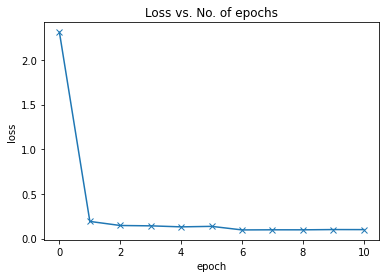

In [83]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');